# Spectral Bias Analysis using Trace Jacobian of PINN Loss Terms for Cavity Flow



In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
import os
import torch
import gc
from matplotlib import pyplot as plt

Import local packages

In [7]:
from src.utils.logger import Logging
from src.utils.color import model_color
from src.utils.plot_spectral import plot_spectral

Set various constant variables: model path, name, etc. We choose the best performing models from each architecture.

In [8]:
TEST_CHECKPOINT_PATH = os.path.join("result/cavity")
logger = Logging(TEST_CHECKPOINT_PATH)
result_dir = logger.get_output_dir()

In [14]:
TANH_NORM_DIST = "./checkpoints/2025-05-27_20-15-51-819301/model.pth"
TANH_PARAM_DIST = ""
BSPLINE_DIST = "./checkpoints/2025-05-27_20-55-49-316995/model.pth"
GRBF_DIST = ""
FOURIER_DIST = ""
CHEBTSHEV_DIST = ""
JACOBI_DIST = ""


MODEL_PATH_LIST = {
    "tanh": TANH_NORM_DIST,
    # "param_tanh": TANH_PARAM_DIST,
    # # "grbf": GRBF_DIST,
    "bspline": BSPLINE_DIST,
    # "chebyshev": CHEBTSHEV_DIST,
    # # "jacobi": JACOBI_DIST,
    # # "fourier": FOURIER_DIST,
}

## Load the saved models 

In [16]:
len(trace_jacobian_bc_log)

16

In [15]:
trace_jacobian_bc_log_dic = {}
trace_jacobian_res_log_dic = {}
trace_jacobian_ic_log_dic = {}

for model_name, model_path in MODEL_PATH_LIST.items():
    logger.print(f"MODEL_PATH {model_path}")

    state = torch.load(
        model_path,
    )
    config = state.get("config", {})
    solver = config.get("solver")
    trace_jacobian_bc_log = state.get("trace_jacobian_bc_log")
    trace_jacobian_ic_log = state.get("trace_jacobian_ic_log")
    trace_jacobian_res_log = state.get("trace_jacobian_res_log")

    model_activation_name = config.get("activation")
    model_architecture = config.get("network")
    loss_dict = state.get("loss_history")

    logger.print(f"activation:  , {model_activation_name}")
    logger.print(f"problem: {config.get('problem')}")
    logger.print(f"solver:  , {solver}")
    logger.print(f"network:  , {config.get('network')}")
    logger.print(f"term loss weights :  , {config.get('weights')}")

    # logger.print(
    #     f"Model {model_name} with iterations: {len(loss_dict[next(iter(loss_dict))])}"
    # )

    trace_jacobian_bc_log_dic[model_name] = trace_jacobian_bc_log
    trace_jacobian_res_log_dic[model_name] = trace_jacobian_res_log
    trace_jacobian_ic_log_dic[model_name] = trace_jacobian_ic_log

    logger.print("******************************\n")
    gc.collect()
    torch.cuda.empty_cache()

logger.print("file directory:", logger.get_output_dir())

INFO:src.utils.logger:MODEL_PATH ./checkpoints/2025-05-27_20-15-51-819301/model.pth
INFO:src.utils.logger:activation:  , None
INFO:src.utils.logger:problem: cavity
INFO:src.utils.logger:solver:  , tanh
INFO:src.utils.logger:network:  , [3, 300, 300, 300, 3]
INFO:src.utils.logger:term loss weights :  , [2.0, 2.0, 2.0, 2.0, 4.0, 0.1]
INFO:src.utils.logger:******************************



INFO:src.utils.logger:MODEL_PATH ./checkpoints/2025-05-27_20-55-49-316995/model.pth
INFO:src.utils.logger:activation:  , None
INFO:src.utils.logger:problem: cavity
INFO:src.utils.logger:solver:  , bspline
INFO:src.utils.logger:network:  , [3, 100, 100, 100, 3]
INFO:src.utils.logger:term loss weights :  , [2.0, 2.0, 2.0, 2.0, 4.0, 0.1]
INFO:src.utils.logger:******************************

INFO:src.utils.logger:file directory:
INFO:src.utils.logger:result/cavity/2025-05-27_21-36-52-215186


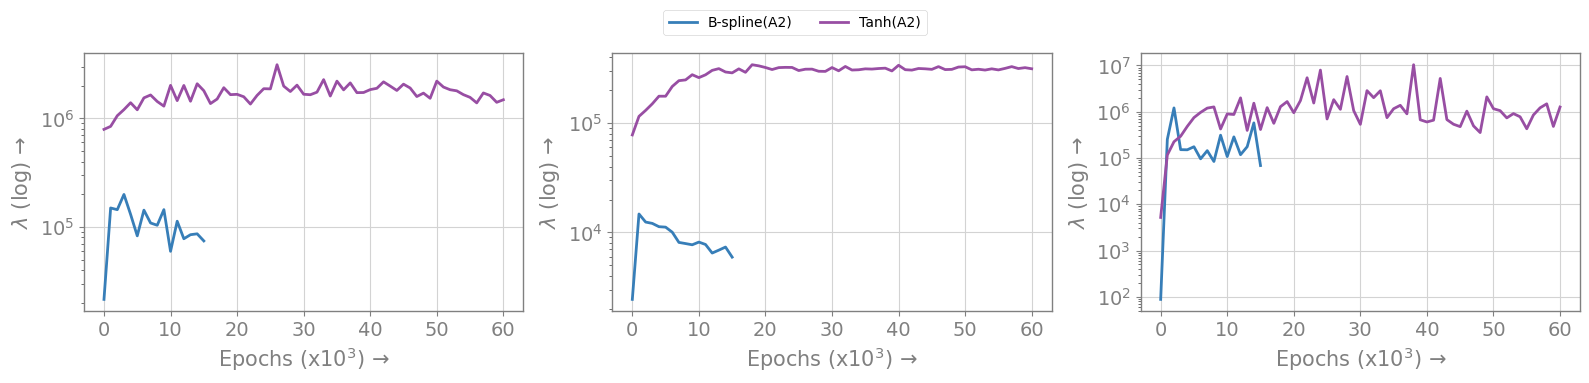

In [17]:
fig, ax = plt.subplots(1, 3)
fig.set_size_inches([16, 3.5])
dict_list = [
    trace_jacobian_bc_log_dic,
    trace_jacobian_ic_log_dic,
    trace_jacobian_res_log_dic,
]
lines = []
labels = []

for index in range(len(dict_list)):
    data_list = [
        {
            "data": dict_list[index]["bspline"],
            "color": model_color["bspline"],
            "name": "B-spline(A2)",
            "alpha": 1.0,
        },
        {
            "data": dict_list[index]["tanh"],
            "color": model_color["tanh"],
            "name": "Tanh(A2)",
            "alpha": 1.0,
        },
        # {
        #     "data": dict_list[index]["grbf"],
        #     "color": model_color["grbf"],
        #     "name": "GRBF(A1)",
        #     "alpha": 1.0,
        # },
        # {
        #     "data": dict_list[index]["fourier"],
        #     "color": model_color["fourier"],
        #     "name": "Fourier(A1)",
        #     "alpha": 1.0,
        # },
        # {
        #     "data": dict_list[index]["param_tanh"],
        #     "color": model_color["param_tanh"],
        #     "name": "parametric-Tanh(A1)",
        #     "alpha": 1.0,
        # },
        # {
        #     "data": dict_list[index]["chebyshev"],
        #     "color": model_color["chebyshev"],
        #     "name": "Chebyshev(A2)",
        #     "alpha": 1.0,
        # },
        # {
        #     "data": dict_list[index]["jacobi"],
        #     "color": model_color["jacobi"],
        #     "name": "Jacobi(A1)",
        #     "alpha": 1.0,
        # },
    ]

    plot_spectral(ax[index], data_list)


for line in ax[-1].get_lines():
    lines.append(line)
    labels.append(line.get_label())

save_path = os.path.join(logger.get_output_dir(), "trace_jacobian_cavity.png")

legend = fig.legend(
    lines, labels, loc="upper center", bbox_to_anchor=(0.5, 1.1), ncol=7
)
legend.get_frame().set_facecolor("white")

plt.tight_layout()
plt.savefig(save_path)